In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
from itertools import product

import Orange
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from sbm_neighbour_score import sbm_neighbour_score, graph_neighbour_score
from utils import Datasets_Data, calc_avranks

In [3]:
data_hub = Datasets_Data()
results, results_modularity_any3, modularity_results = data_hub.load_precalculated()

# Analyze results of Datasets

In [4]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(data_hub.datasets, data_hub.kernels_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

cora_Net: 0.18
cora_DB: 0.18
cora_EC: 0.27
cora_IR: 0.30
eu-core: 0.34
cora_HA: 0.38
news_5cl3_0.1: 0.42
news_5cl2_0.1: 0.49
cora_HCI: 0.51
news_5cl1_0.1: 0.61
news_3cl2_0.1: 0.62
news_3cl3_0.1: 0.66
news_2cl2_0.1: 0.67
polbooks: 0.69
sp_school_day_1: 0.72
news_3cl1_0.1: 0.73
news_2cl1_0.1: 0.73
polblogs: 0.73
sp_school_day_2: 0.74
eurosis: 0.74
news_2cl3_0.1: 0.83
football: 0.87
dolphins: 0.93
karate: 1.00


In [5]:
dataset_modularity = modularity_results
for dataset, modularity in sorted(list(modularity_results.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

cora_EC: 0.19
sp_school_day_1: 0.29
eu-core: 0.31
sp_school_day_2: 0.32
news_2cl2_0.1: 0.34
cora_Net: 0.35
karate: 0.37
dolphins: 0.37
news_2cl1_0.1: 0.38
cora_IR: 0.38
polblogs: 0.41
polbooks: 0.41
news_2cl3_0.1: 0.42
news_5cl3_0.1: 0.42
cora_DB: 0.43
news_3cl2_0.1: 0.46
news_5cl2_0.1: 0.50
news_3cl3_0.1: 0.51
news_3cl1_0.1: 0.53
cora_HCI: 0.53
football: 0.55
news_5cl1_0.1: 0.56
cora_HA: 0.61
eurosis: 0.70


## CD diagram

n_experiments: 4200


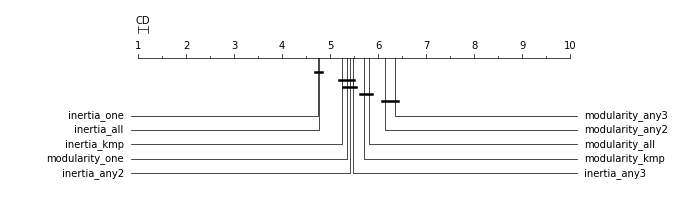

In [6]:
avranks, names, n_experiments = calc_avranks(results) # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

n_experiments: 168


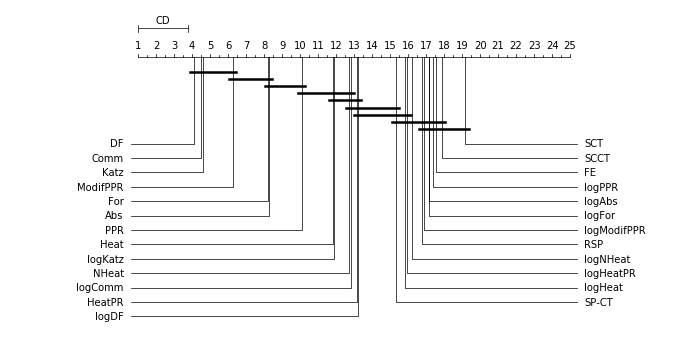

In [7]:
avranks, names, n_experiments = calc_avranks(results_modularity_any3)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

## Group datasets by measure ranking

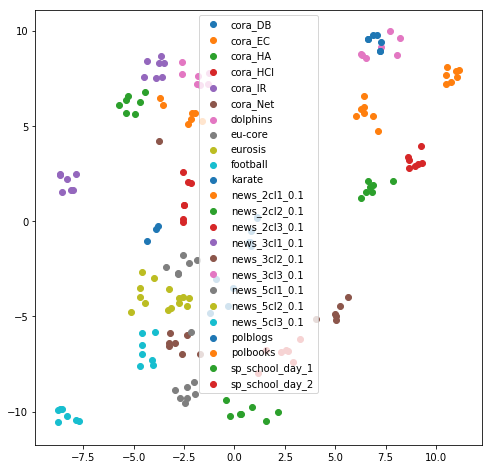

In [8]:
dataset_graphidx_avranks = dict()
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks({'0': dataset_results})
    dataset_graphidx_avranks[dataset_name] = avranks
    
# TSNE
X_embedded = TSNE(n_components=2, learning_rate=100).fit_transform(list(dataset_graphidx_avranks.values()))

dataset_embedding = defaultdict(list)  # {dataset: [embedding]}
for (dataset, graph_idx), X_embedded_item in zip(list(dataset_graphidx_avranks.keys()), X_embedded):
    dataset_embedding[dataset].append(X_embedded_item)
    
plt.subplots(1, figsize=(8, 8))
for dataset, embedding in dataset_embedding.items():
    embedding = np.array(embedding)
    plt.scatter(embedding[:, 0], embedding[:, 1], label=dataset)
plt.legend()

In [9]:
dataset_avranks = dict()  # {dataset: avranks}
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks(dataset_results)
    dataset_avranks[dataset_name] = avranks

n_clusters = 3
# kmeans = KMeans(n_clusters=n_clusters)
kmeans = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
kmeans.fit(list(dataset_avranks.values()))

datasets_partition = []  # [[dataset]]
for class_idx in range(n_clusters):
    datasetss = [dataset_name for dataset_name, label in zip(list(dataset_avranks.keys()), kmeans.labels_) if label == class_idx]
    datasets_partition.append(datasetss)
    
for i in range(n_clusters):
    print(f'Partition {i}')
    print(f'  {", ".join(datasets_partition[i])}')

Partition 0
  cora_DB, cora_IR, cora_Net, eu-core, eurosis, football, news_2cl3_0.1, news_3cl2_0.1, news_5cl1_0.1, news_5cl2_0.1, news_5cl3_0.1, polblogs, sp_school_day_1, sp_school_day_2
Partition 1
  cora_EC, cora_HA, cora_HCI, dolphins, karate, polbooks
Partition 2
  news_2cl1_0.1, news_2cl2_0.1, news_3cl1_0.1, news_3cl3_0.1


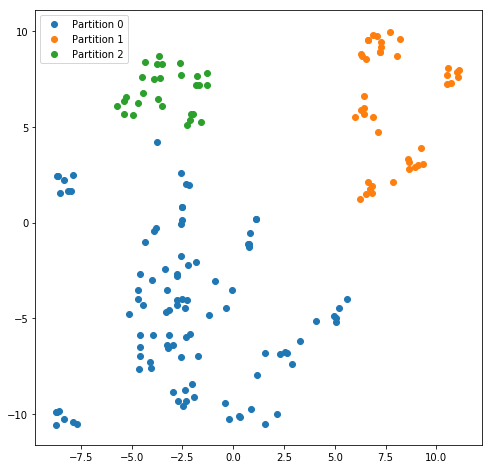

In [10]:
plt.subplots(1, figsize=(8, 8))
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    embedding_filtered = []
    for dataset in datasetss:
        embedding_filtered.extend(dataset_embedding[dataset])
    embedding_filtered = np.array(embedding_filtered)
    plt.scatter(embedding_filtered[:, 0], embedding_filtered[:, 1], label=f'Partition {class_idx}')
plt.legend()

Item cora_DB not in cache; reload
Item cora_IR not in cache; reload
Item cora_Net not in cache; reload
Item eu-core not in cache; reload
Item eurosis not in cache; reload
Item football not in cache; reload
Item news_2cl3_0.1 not in cache; reload
Item news_3cl2_0.1 not in cache; reload
Item news_5cl1_0.1 not in cache; reload
Item news_5cl2_0.1 not in cache; reload
Item news_5cl3_0.1 not in cache; reload
Item polblogs not in cache; reload
Item sp_school_day_1 not in cache; reload
Item sp_school_day_2 not in cache; reload
Item cora_EC not in cache; reload
Item cora_HA not in cache; reload
Item cora_HCI not in cache; reload
Item dolphins not in cache; reload
Item karate not in cache; reload
Item polbooks not in cache; reload
Item news_2cl1_0.1 not in cache; reload
Item news_2cl2_0.1 not in cache; reload
Item news_3cl1_0.1 not in cache; reload
Item news_3cl3_0.1 not in cache; reload


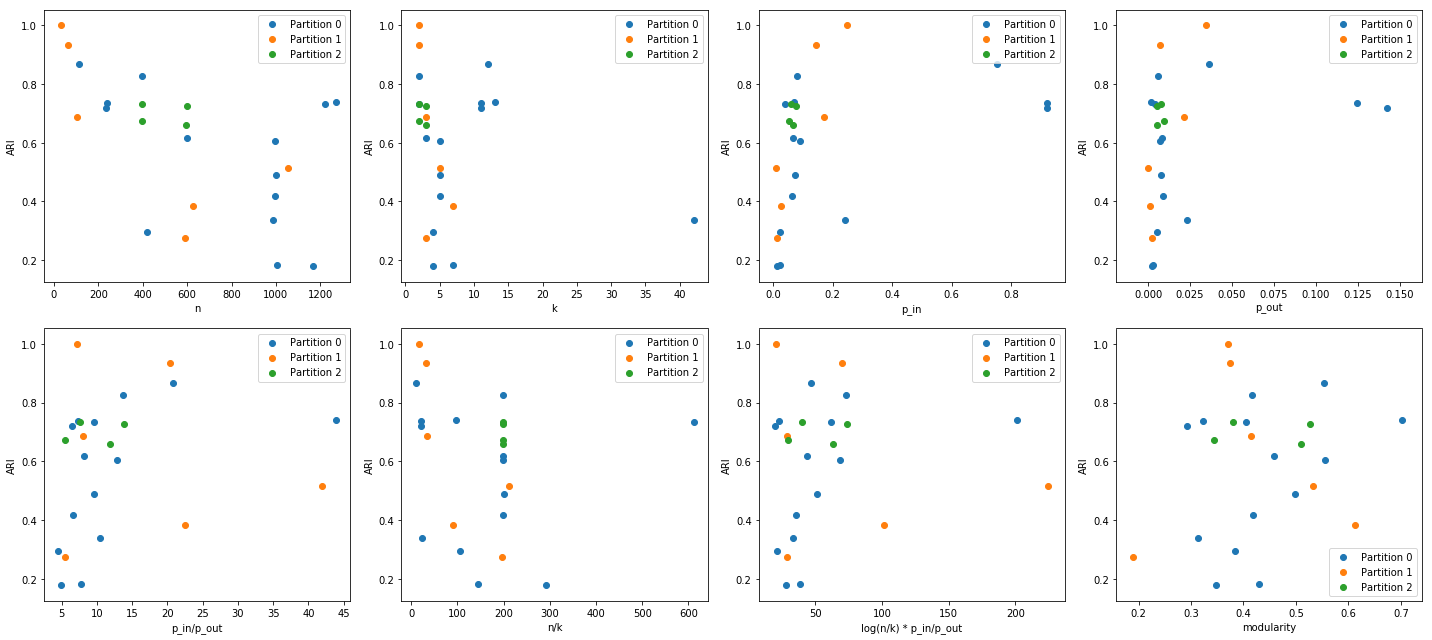

In [11]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 4, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out', 'p_in/p_out', 'n/k', 'log(n/k) * p_in/p_out']):
    for class_idx in range(n_clusters):
        datasetss = datasets_partition[class_idx]
        x, y = [], []
        for dataset in datasetss:
            x.append(data_hub.extract_feature(dataset, feature))
            y.append(dataset_meanari[dataset])
        sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
    ax[idx].set_xlabel(feature)
    ax[idx].set_ylabel('ARI')
    ax[idx].legend(loc=1)

idx = 7
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

plt.tight_layout()

Partition 0, n_experiments: 98
  cora_DB, cora_IR, cora_Net, eu-core, eurosis, football, news_2cl3_0.1, news_3cl2_0.1, news_5cl1_0.1, news_5cl2_0.1, news_5cl3_0.1, polblogs, sp_school_day_1, sp_school_day_2


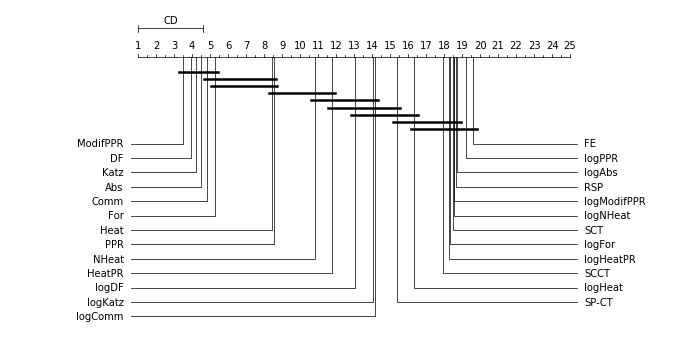

Partition 1, n_experiments: 42
  cora_EC, cora_HA, cora_HCI, dolphins, karate, polbooks


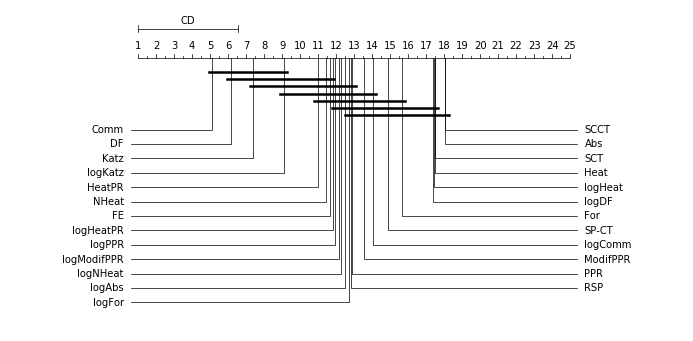

Partition 2, n_experiments: 28
  news_2cl1_0.1, news_2cl2_0.1, news_3cl1_0.1, news_3cl3_0.1


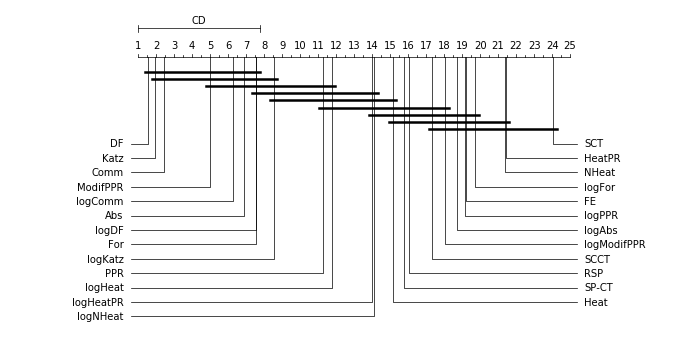

In [12]:
for group_idx, datasets_group in enumerate(datasets_partition):
    results_filtered = {k: v for k, v in results.items() if k[0] in datasets_group}
    results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
    for (dataset, kernel_name, graph_idx), si_ari in results_filtered.items():
        results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

    avranks, names, n_experiments = calc_avranks(results_modularity_any3)
    print(f'Partition {group_idx}, n_experiments: {n_experiments}')
    print(f'  {", ".join(datasets_partition[group_idx])}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
    plt.show()

# SBM neighbour score

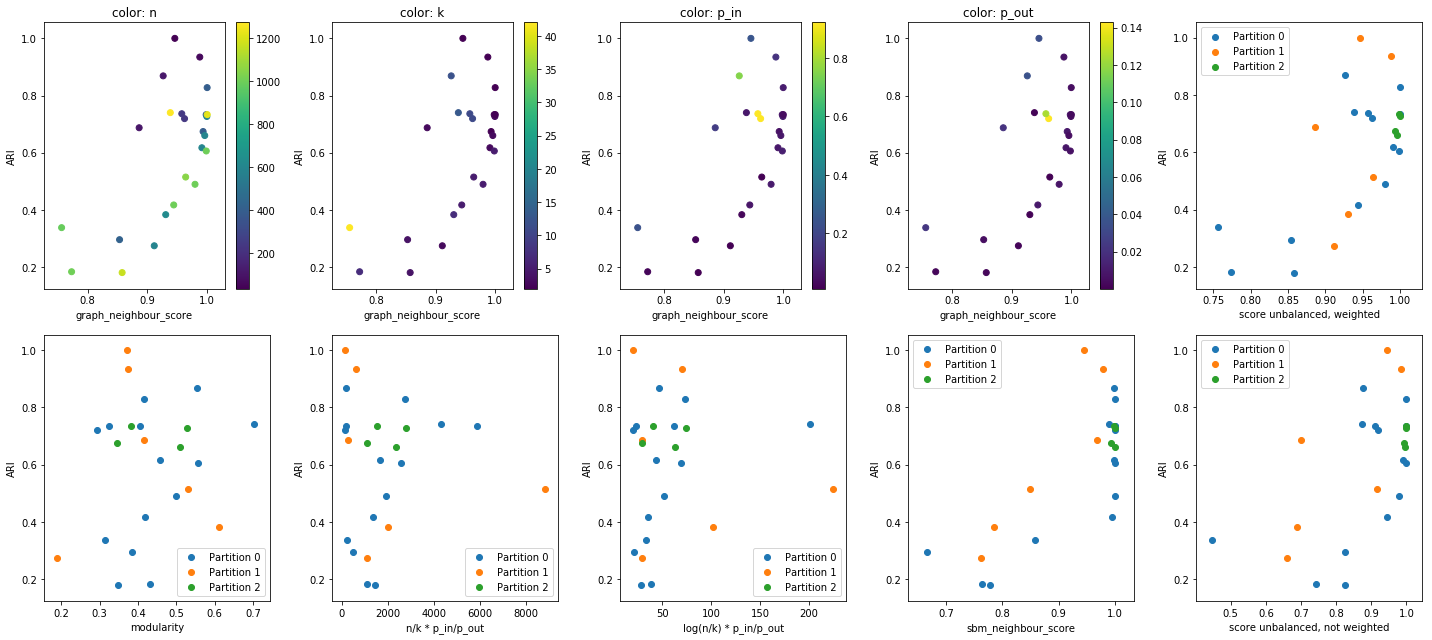

In [13]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 5, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out']):
    x, y, v = [], [], []
    for dataset in data_hub.datasets:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score'))
        y.append(dataset_meanari[dataset])
        v.append(data_hub.extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v)
    ax[idx].set_xlabel('graph_neighbour_score')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])

idx += 1

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'n/k * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('n/k * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'log(n/k) * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('log(n/k) * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('sbm_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)


idx = 4
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('score unbalanced, weighted')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

idx = 9
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score_noweight'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('score unbalanced, not weighted')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

plt.tight_layout()

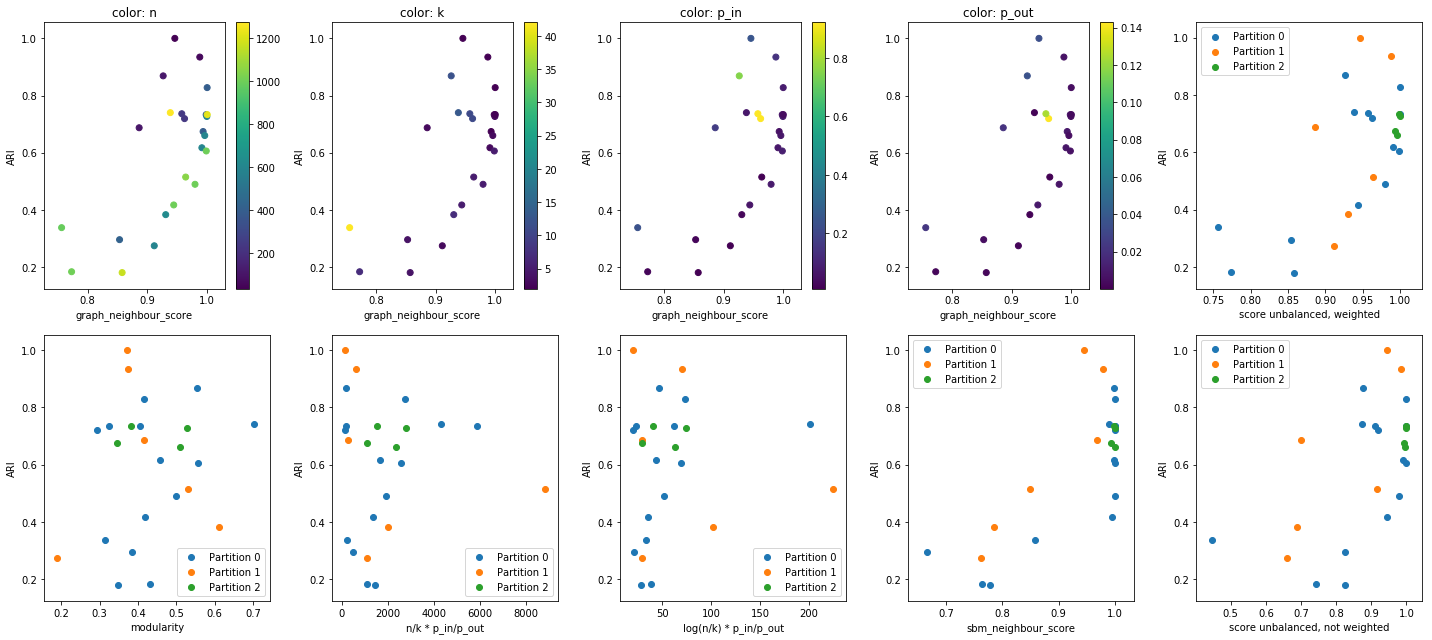

In [15]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 5, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out']):
    x, y, v = [], [], []
    for dataset in data_hub.datasets:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score'))
        y.append(dataset_meanari[dataset])
        v.append(data_hub.extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v)
    ax[idx].set_xlabel('graph_neighbour_score')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])

idx += 1

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'n/k * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('n/k * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'log(n/k) * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('log(n/k) * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx += 1
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('sbm_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)


idx = 4
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('score unbalanced, weighted')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

idx = 9
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'graph_neighbour_score_noweight'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('score unbalanced, not weighted')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

plt.tight_layout()